# Breast Cancer Recurrence Prediction using Machine Learning

## Exploratory Data Analysis

### Dataset

The data is provided as two separate ```.data``` files<br>
- ```breast-cancer.data```, containing the dataset 
- ```breast-cancer.names```, containing relevant informations about the dataset

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.stats.power import TTestIndPower
from scipy.stats import chi2_contingency
import missingno as msno

from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', None) #setting max colwidth to view the entire dataset when using the print() command
from IPython.display import display
%matplotlib inline
import matplotlib.patches as mpatches


# set random seed
np.random.seed(42)

In [2]:
# preview the informations provided with the dataset
data_info = open("./dataset/breast-cancer.names").read()
print(data_info)

Citation Request:
   This breast cancer domain was obtained from the University Medical Centre,
   Institute of Oncology, Ljubljana, Yugoslavia.  Thanks go to M. Zwitter and 
   M. Soklic for providing the data.  Please include this citation if you plan
   to use this database.

1. Title: Breast cancer data (Michalski has used this)

2. Sources: 
   -- Matjaz Zwitter & Milan Soklic (physicians)
      Institute of Oncology 
      University Medical Center
      Ljubljana, Yugoslavia
   -- Donors: Ming Tan and Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
   -- Date: 11 July 1988

3. Past Usage: (Several: here are some)
     -- Michalski,R.S., Mozetic,I., Hong,J., & Lavrac,N. (1986). The 
        Multi-Purpose Incremental Learning System AQ15 and its Testing 
        Application to Three Medical Domains.  In Proceedings of the 
        Fifth National Conference on Artificial Intelligence, 1041-1045,
        Philadelphia, PA: Morgan Kaufmann.
        -- accuracy range: 66%-72%
     -

In [3]:
# import and preview the dataset
data = pd.read_csv('./dataset/breast-cancer.data', header=None)
data.columns = ['class', 'age', 'menopause', 'tumour_size', 'inv_nodes', 'node_caps', 'deg_malig', 'breast', 'breast_quad', 'irrad']
data.head(3)

,class,age,menopause,tumour_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,irrad
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no


Variables in this dataset are:

***Class***: whether or not there has been a recurrence of cancer<br>
***Age***: patient's age at the time of diagnosis<br>
***Menopause***: menopausal status of the patient at the time of diagnosis, pre-menopausal (*premeno*) or post-menopausal (*ge40*, *lt40*) at the time of diagnosis:<br>
***Tumour Size***: the size of the tumour (mm) at the time of diagnosis<br>
***Invasive Nodes***: the total number of lymph nodes confirming Breast Cancer at the time of the histological examination<br>
***Node Caps***: whether the tumour penetrated in the lymph node capsule<br>
***Degree of Malignancy***: divided into 1 -2 or 3, depending on the malignancy of the tumour<br>
***Breast***: the position of the tumour (left or right breast)<br>
***Breast Quadrant***: the quadrant of the breast where the tumour is present<br>
***Irradiation***: whether radiation therapy has been used as a treatment to destroy cancer cells<br>

*7. Attribute Information*. It is specified that the dataset includes missing values denoted with the attribute **'?'**

In [4]:
# replace missing values from ? to np.NaN
data = data.replace("?", np.nan)

### Power Analysis

I want to determine if the available data points included in the provided dataset are enough to successfully train a model for the objective stated.<br>
For this prediction model, I want to avoid as much as possible false positives and especially false negatives.<br>
I will use power analysis and set:
- Effect Size to 0.5
- Alpha to 0.001
- Power to 0.9

Most of the features are categorical type data. To run the power analysis I will need to store the dataset into a new variable ```power_analysis``` and convert the categorical data type to numerical data type. 

In [5]:
# save dataset to new variable
power_analysis = data[['class', 'age', 'menopause', 'tumour_size', 'inv_nodes', 'node_caps', 'deg_malig', 'breast', 'breast_quad', 'irrad']]
power_analysis.head(3)

,class,age,menopause,tumour_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,irrad
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no


In [6]:
# convert data columns to numerical type except for deg_malig
for col in power_analysis.columns:
    if col != 'deg_malig':
        power_analysis[col] = pd.Categorical(power_analysis[col]).codes
    else:
        continue

power_analysis.head(3)

,class,age,menopause,tumour_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,irrad
0,0,1,2,5,0,0,3,0,1,0
1,0,2,2,3,0,0,2,1,4,0
2,0,2,2,3,0,0,2,0,1,0


In [7]:
# Define effect size, alpha, and power
effect_size = 0.5
alpha = 0.001
power = 0.9

# Count the total number of categories across all categorical features
n_classes = len(set(power_analysis[power_analysis.columns].values.flatten()))


# Create a TTestIndPower object for a two-sample t-test
analysis = TTestIndPower()

# Calculate the required sample size
sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power)

print('Required Sample Size:', round(sample_size))

Required Sample Size: 170


#### Sensitivity Analysis

In [8]:
# Define a list of effect sizes to test
effect_sizes = [0.2, 0.8]

# Calculate the required sample size for each effect size
for effect_size in effect_sizes:
    sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power)
    print(f"Effect size: {effect_size}, Required sample size: {round(sample_size)}")

Effect size: 0.2, Required sample size: 1048
Effect size: 0.8, Required sample size: 68


#### Achieved Power

In [9]:
effect_size = 0.5
alpha = 0.001

# Count the total number of categories across all categorical features
n_classes = len(set(power_analysis[power_analysis.columns].values.flatten()))

# Create a TTestIndPower object for a two-sample t-test
analysis = TTestIndPower()

# Define the sample size
sample_size = 200

# Calculate the achieved power
achieved_power = analysis.power(effect_size=effect_size, nobs1=sample_size, alpha=alpha, ratio=1, df=None, alternative='two-sided')

print(f"Achieved power: ", round(achieved_power,2))

Achieved power:  0.95


The dataset is large enough to continue working on the prediction model.

### Identify and Explore the target attribute

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumour_size  286 non-null    object
 4   inv_nodes    286 non-null    object
 5   node_caps    278 non-null    object
 6   deg_malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast_quad  285 non-null    object
 9   irrad        286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


The aim of the ML model is to **predict wether a given patient is subject to experience a recurrence** after being treated for breast cancer.<br>

Given the dataset I have identified ```'class'``` as the perfect target attribute.<br>
This feature is categorical and contains text-type data *(no-recurrence-events, recurrence-events)*<br>

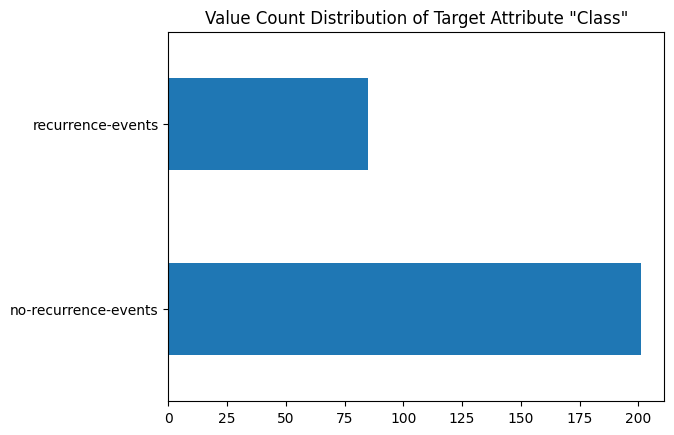

In [11]:
class_ = data['class'].value_counts()
class_.plot.barh()
plt.title('Value Count Distribution of Target Attribute "Class"')
plt.show()

About 70% of the dataset includes patients that didn't experience a recurrence of the disease. This means, and it is clearly shown, that the target attribute is heavily **unbalanced**. Machine learning models assume the data is balanced and perform poorly on imbalanced data, often predicting the majority value more frequently than the minority value. Some sampling might be necessary later on in the data processing step.

### Split the dataset into Train and Test set

In [12]:
X = data.drop(['class'], axis = 1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Preview the Train set DataFrame

In [13]:
X_train.head()

,age,menopause,tumour_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,irrad
215,40-49,ge40,20-24,0-2,no,2,right,left_up,no
41,60-69,ge40,25-29,0-2,no,2,left,left_low,no
24,50-59,premeno,35-39,0-2,no,2,right,left_up,no
161,40-49,premeno,30-34,3-5,yes,2,right,left_low,no
144,60-69,ge40,45-49,6-8,yes,3,left,central,no


In [14]:
y_train.head()

215       recurrence-events
41     no-recurrence-events
24     no-recurrence-events
161    no-recurrence-events
144    no-recurrence-events
Name: class, dtype: object

### Explore the Train set

#### Identify Missing Values

Text(0.5, 1.0, 'Missing Values Matrix Plot')

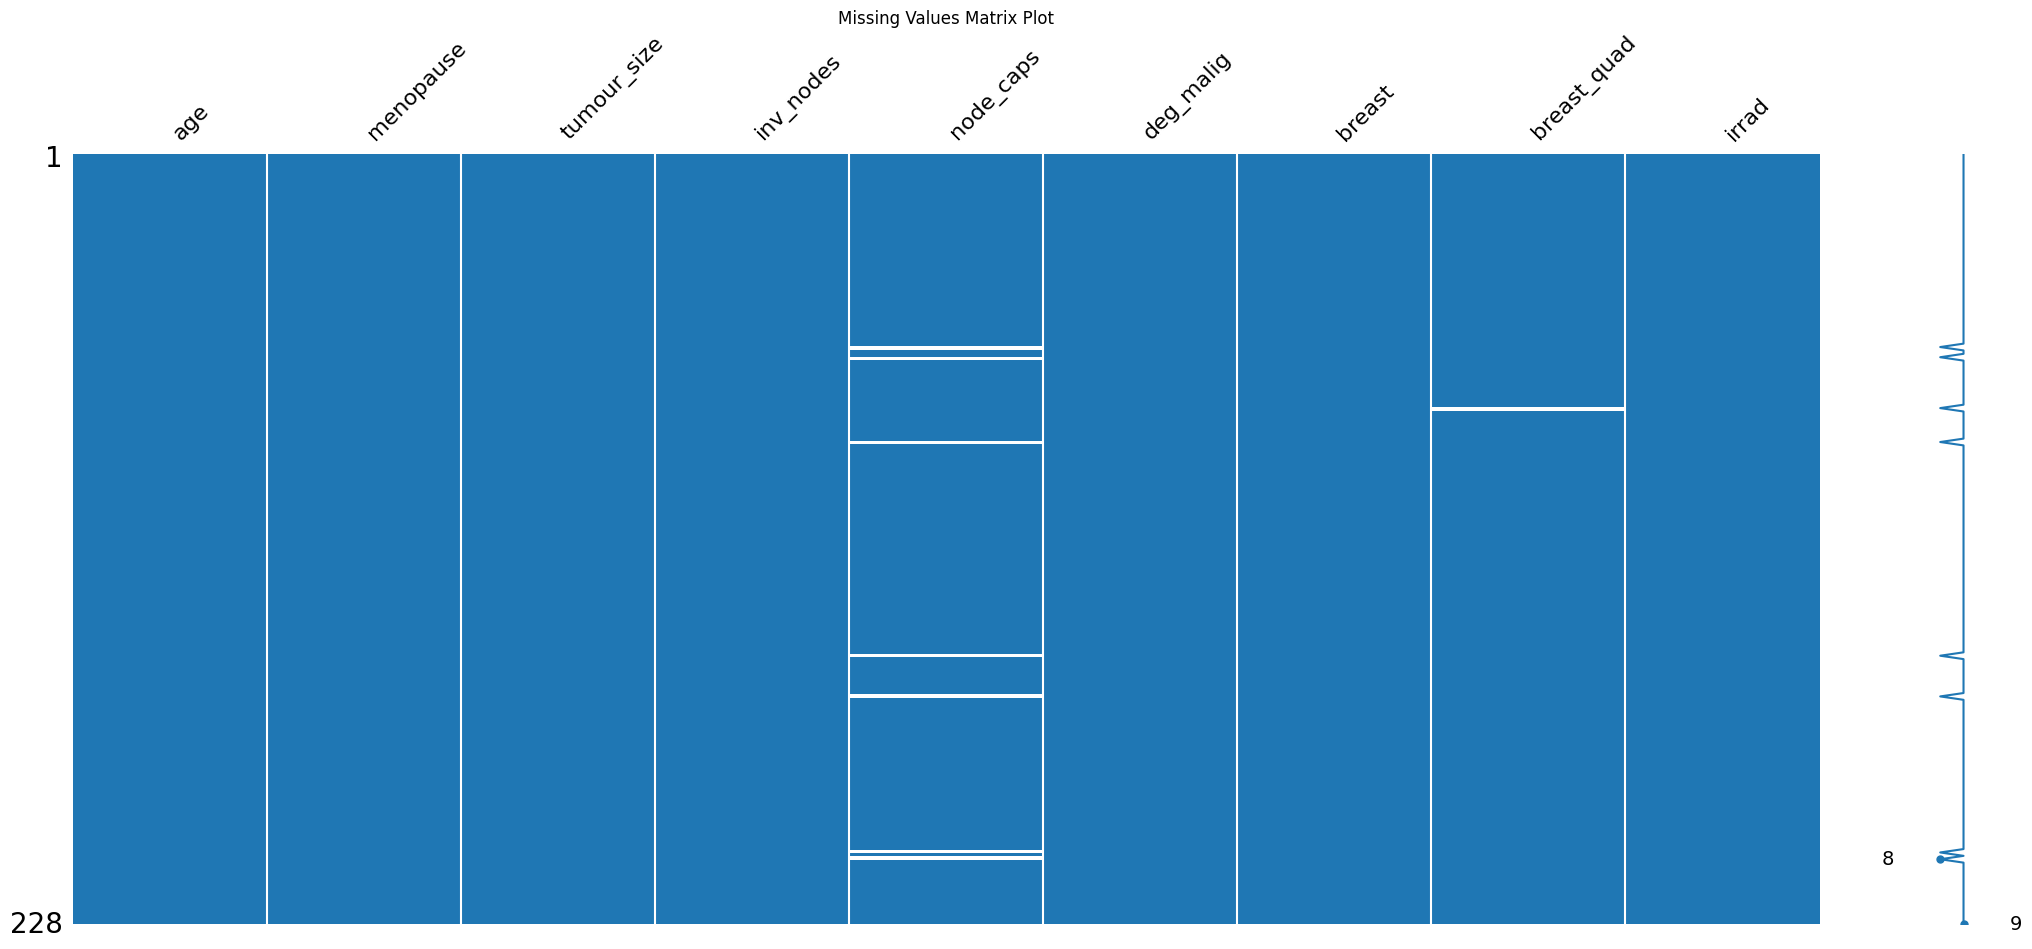

In [15]:
# identify where the missing values are in the dataset
msno.matrix(X_train, color=(0.12156863, 0.46666667, 0.70588235))
plt.title("Missing Values Matrix Plot")

In [16]:
# find % of missing values per single attribute in the dataset
nan = X_train.isna().sum()
tot = X_train.count()
perc = (nan*100)/tot
round(perc,2)

age            0.00
menopause      0.00
tumour_size    0.00
inv_nodes      0.00
node_caps      3.17
deg_malig      0.00
breast         0.00
breast_quad    0.44
irrad          0.00
dtype: float64

#### Explore the values distribution of the attributes on Train set

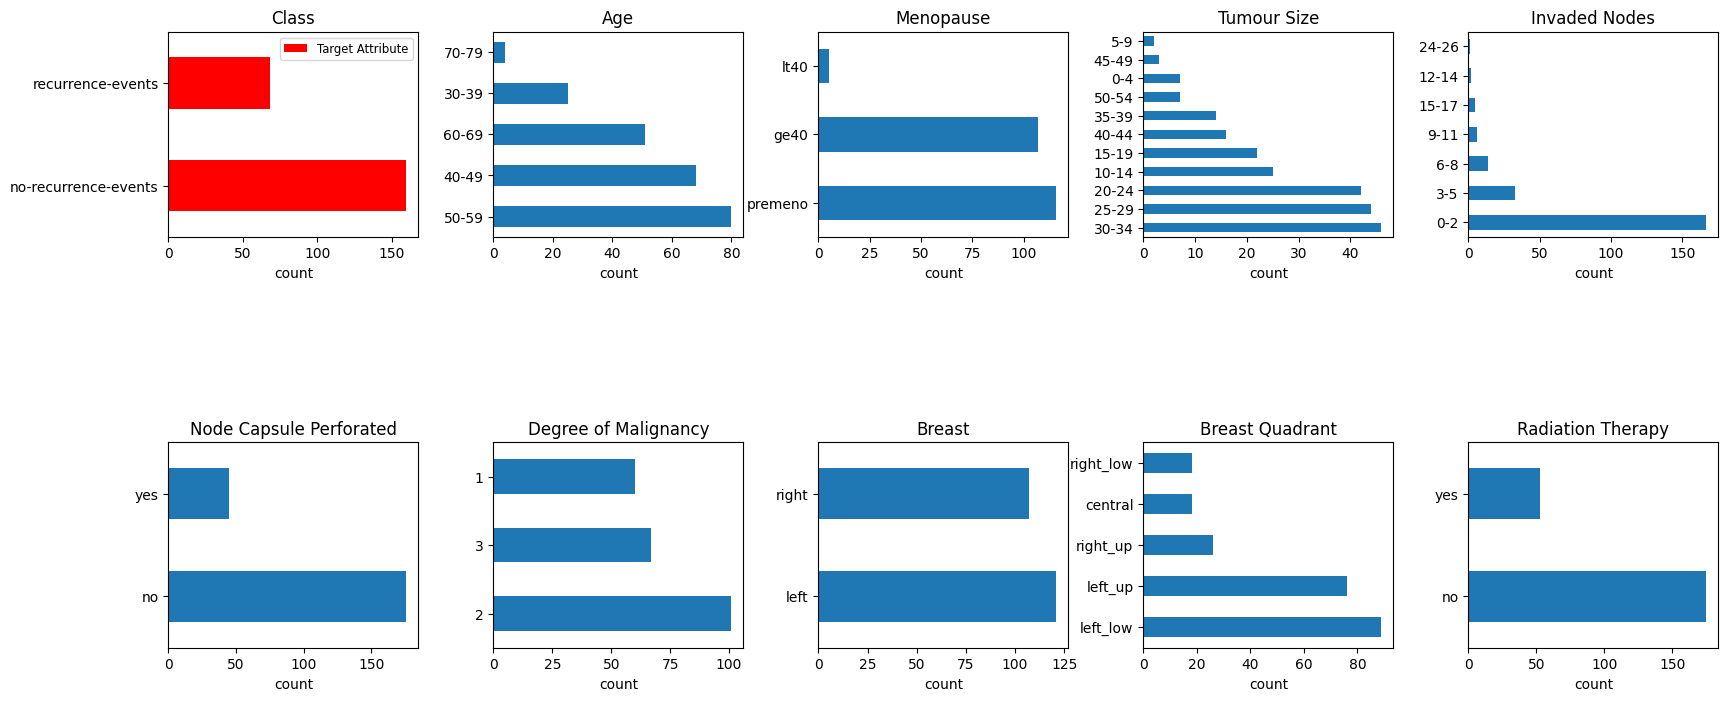

In [17]:
class_ = y_train.value_counts()
age_ = X_train['age'].value_counts()
menopause_ = X_train['menopause'].value_counts()
tumour_size_ = X_train['tumour_size'].value_counts()
inv_nodes_ = X_train['inv_nodes'].value_counts()
node_caps_ = X_train['node_caps'].value_counts()
deg_malig_ = X_train['deg_malig'].value_counts()
breast_ = X_train['breast'].value_counts()
breast_quad_ = X_train['breast_quad'].value_counts()
irrad_ = X_train['irrad'].value_counts()




# Create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 5, gridspec_kw={'height_ratios': [12,12]})
fig.set_size_inches(20,8)



class_.plot.barh(ax=axs[0, 0], color='r')
age_.plot.barh(ax=axs[0, 1])
menopause_.plot.barh(ax=axs[0, 2])
tumour_size_.plot.barh(ax=axs[0, 3])
inv_nodes_.plot.barh(ax=axs[0, 4])
node_caps_.plot.barh(ax=axs[1, 0])
deg_malig_.plot.barh(ax=axs[1, 1])
breast_.plot.barh(ax=axs[1, 2])
breast_quad_.plot.barh(ax=axs[1, 3])
irrad_.plot.barh(ax=axs[1, 4])


# Set the title for each subplot
axs[0, 0].set_title('Class')
axs[0, 1].set_title('Age')
axs[0, 2].set_title('Menopause')
axs[0, 3].set_title('Tumour Size')
axs[0, 4].set_title('Invaded Nodes')
axs[1, 0].set_title('Node Capsule Perforated')
axs[1, 1].set_title('Degree of Malignancy')
axs[1, 2].set_title('Breast')
axs[1, 3].set_title('Breast Quadrant')
axs[1, 4].set_title('Radiation Therapy')

# Set the x-axis label for each subplot
axs[0, 0].set_xlabel('count')
axs[0, 1].set_xlabel('count')
axs[0, 2].set_xlabel('count')
axs[0, 3].set_xlabel('count')
axs[0, 4].set_xlabel('count')
axs[1, 0].set_xlabel('count')
axs[1, 1].set_xlabel('count')
axs[1, 2].set_xlabel('count')
axs[1, 3].set_xlabel('count')
axs[1, 4].set_xlabel('count')

legend_label = ['Target Attribute']
axs[0, 0].legend(legend_label, loc='upper right', fontsize='small')

plt.subplots_adjust(hspace=1, wspace=0.3)
plt.show()

#### Compute correlation between the attributes

From this correlation analysis I need to exclude ```'deg_malig'``` as the data-type is numerical.

In [18]:
corr = data[data.columns]
corr = corr.drop('deg_malig', axis=1)

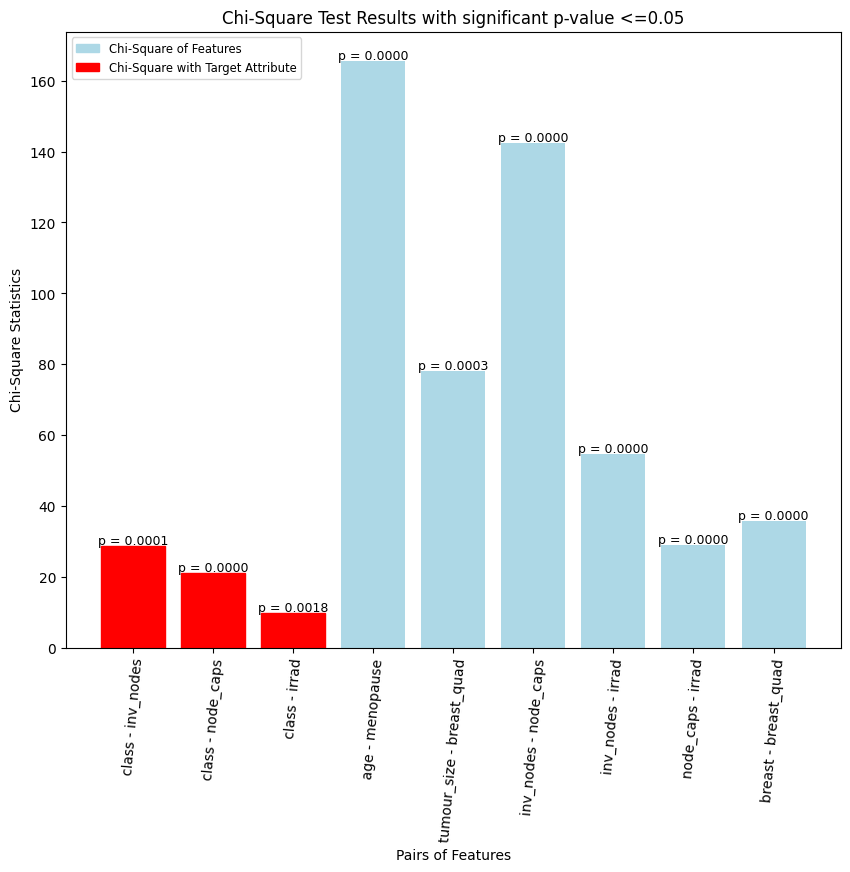

In [19]:
columns = corr.columns
chi_p = []
for i, column1 in enumerate(columns):
    for column2 in columns[i + 1:]:
        table = pd.crosstab(data[column1], data[column2])
        chi2, p, dof, expected = chi2_contingency(table)
        if p<=0.05:
            chi_p.append([column1, column2, chi2, p])
      
    
    #"stat-sign": (p_value < 0.05), # X danio chi2 only for categorial features sign rel only if p<0.05

bar_width = 0.35
# plot the results for chi-squared statistic
x = [f"{result[0]} - {result[1]}" for result in chi_p]
y = [result[2] for result in chi_p]
p = [result[3] for result in chi_p]

fig, ax1 = plt.subplots()
fig.set_size_inches(10,8)
ax1.bar(x, y, color='lightblue')
ax1.set_ylabel('Chi-Square Statistics')

for i, v in enumerate(y):
    ax1.text(i, v + 0.5, f"p = {p[i]:.4f}", ha='center', fontsize=9)


# Highlight bars that correspond to a specific range of x-axis values
highlight_x = ['class - inv_nodes','class - node_caps', 'class - irrad']  # Example of features to highlight
highlight_indices = [x.index(i) for i in highlight_x]  # Get indices of bars that correspond to highlight_x
for index in highlight_indices:
    ax1.get_children()[index].set_color('red')  # Set the color of the bars at the indices to red



# Add legends
ax1.legend(handles=[mpatches.Patch(color='lightblue', label='Chi-Square of Features'),
                     mpatches.Patch(color='red', label='Chi-Square with Target Attribute')], loc='upper left', fontsize='small')



plt.title("Chi-Square Test Results with significant p-value <=0.05")
plt.xlabel("Pairs of Features")
x_labels = [f"{result[0]} - {result[1]}" for result in chi_p]
ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(labels=x_labels, rotation=85)
plt.show()

Based on the correlation analysis between the categorical features, I will exclude ```'age'``` and ```'menopause'``` from the model training due to high and significant correlation which could result in multicollinearity. Notice also a high and significant correlation between ```'inv_nodes'``` and ```'node_caps'``` but I believe they will be usefull for training the model due to their significant correlation with the target feature.

Some significant correlation worth looking at are:
- ```'class'``` with ```'inv_nodes'```, ```'node_caps'```, ```'irrad'``` and ```'deg_malig'```
- ```'tumour_size'``` with ```'breast_quad'```
- ```'inv_nodes'``` with ```'node_caps'``` and ```'irrad'```
- ```'node_caps'``` with ```'irrad'```

For obvious reasons I believe ```'breast'``` and ```'breast_quad'``` represent the same concept and ```'breast'``` might be worth not including it in the training of the ML model

In [20]:
# create a crosstab function for analysis
def crosstab(x,y):
    crosstab = pd.crosstab(
                    data[x],
                    data[y],
                    margins=True,
                    normalize=True,
                )
    crosstab = crosstab.style.highlight_between(left=0.5, right=0.99, color="#276221")
    return crosstab



# function to calculate proportion based on attribute values
def proportion(x,x_n,y,y_n,data):
    tot = data[data[x]==x_n]
    part = tot[tot[y]==y_n]
    part = part[x].value_counts()
    tot = tot[x].value_counts()
    result = round(((part / tot) *100), 2)
    result = float(result)
    return result

In [21]:
# run the functions
crosstab('class', 'inv_nodes')

inv_nodes,0-2,12-14,15-17,24-26,3-5,6-8,9-11,All
class,,,,,,,,
no-recurrence-events,0.583916,0.003497,0.010490,0.000000,0.066434,0.024476,0.013986,0.702797
recurrence-events,0.160839,0.006993,0.010490,0.003497,0.059441,0.034965,0.020979,0.297203
All,0.744755,0.010490,0.020979,0.003497,0.125874,0.059441,0.034965,1.000000


In [22]:
crosstab('class', 'node_caps')

node_caps,no,yes,All
class,,,
no-recurrence-events,0.615108,0.089928,0.705036
recurrence-events,0.183453,0.111511,0.294964
All,0.798561,0.201439,1.000000


In [23]:
crosstab('class', 'irrad')

irrad,no,yes,All
class,,,
no-recurrence-events,0.573427,0.129371,0.702797
recurrence-events,0.188811,0.108392,0.297203
All,0.762238,0.237762,1.000000


In [24]:
crosstab('class', 'deg_malig')

deg_malig,1,2,3,All
class,,,,
no-recurrence-events,0.206294,0.356643,0.139860,0.702797
recurrence-events,0.041958,0.097902,0.157343,0.297203
All,0.248252,0.454545,0.297203,1.000000


In [25]:
corr['inv_nodes'] = corr['inv_nodes'].replace(['0-2','3-5','6-8','9-11','12-14','15-17','24-26'],[0,1,2,3,4,5,6])

# run through a while loop to iterate proportion() for 7 times
count = 0  
lis = [] # list to append results and plot later

while count < 7:
    res = proportion('inv_nodes',count,'class','recurrence-events',corr)
    lis.append(res)
    count +=1

yax3 = np.array(lis)


bp1_1 = proportion('node_caps','yes','class','recurrence-events',data)
bp2_1 = proportion('node_caps','no','class','recurrence-events',data)
bp3_1 = proportion('node_caps','yes','class','no-recurrence-events',data)

bp1_2 = proportion('deg_malig',3,'class','recurrence-events',data)
bp2_2 = proportion('deg_malig',1,'class','no-recurrence-events',data)
bp3_2 = proportion('deg_malig',2,'class','no-recurrence-events',data)

bp1_3 = proportion('irrad','yes','class','recurrence-events',data)
bp2_3 = proportion('irrad','no','class','recurrence-events',data)
bp3_3 = proportion('irrad','yes','class','no-recurrence-events',data)

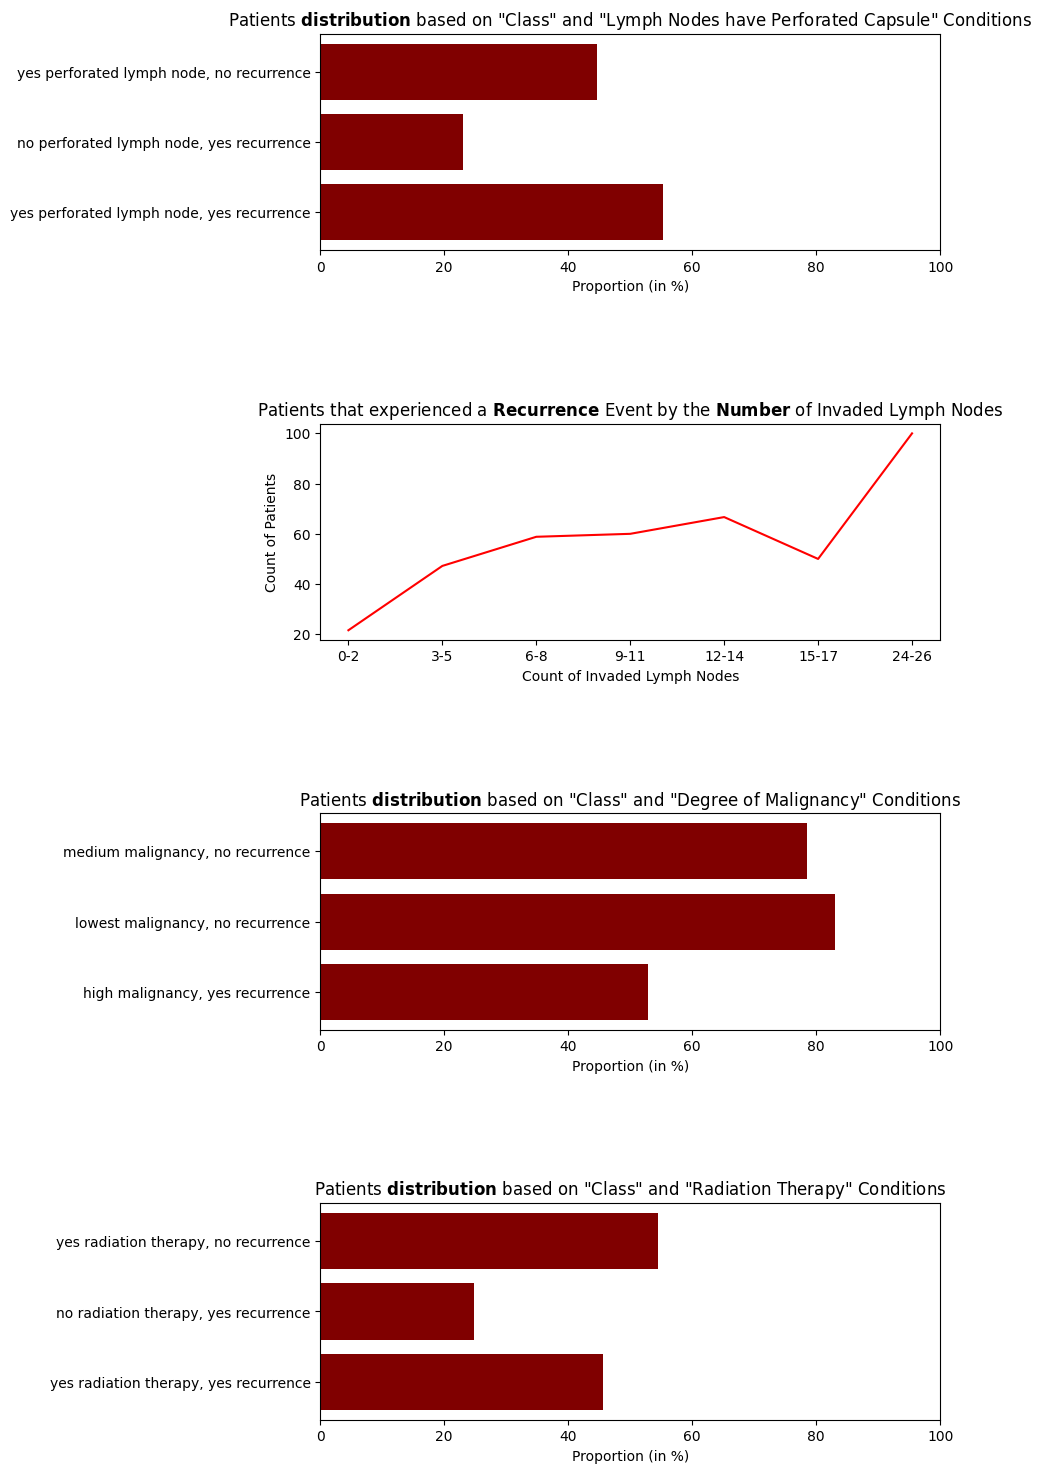

In [26]:
# create a subplot layout with three subplots
fig, (ax2, ax3, ax4, ax5) = plt.subplots(4, 1, gridspec_kw={'height_ratios': [10,10,10,10]})
fig.set_size_inches(8,18)


# add each of the individual plots to its corresponding subplot

ax2.barh(['yes perforated lymph node, yes recurrence','no perforated lymph node, yes recurrence', 'yes perforated lymph node, no recurrence'], [bp1_1,bp2_1,bp3_1], color='maroon')
ax3.plot(yax3, color = 'r')
ax4.barh(['high malignancy, yes recurrence','lowest malignancy, no recurrence', 'medium malignancy, no recurrence'], [bp1_2,bp2_2,bp3_2], color='maroon')
ax5.barh(['yes radiation therapy, yes recurrence','no radiation therapy, yes recurrence', 'yes radiation therapy, no recurrence'], [bp1_3,bp2_3,bp3_3], color='maroon')


ax2.set_title(r'Patients $\bf{distribution}$ based on "Class" and "Lymph Nodes have Perforated Capsule" Conditions')
ax3.set_title(r'Patients that experienced a $\bf{Recurrence}$ Event by the $\bf{Number}$ of Invaded Lymph Nodes')
ax4.set_title(r'Patients $\bf{distribution}$ based on "Class" and "Degree of Malignancy" Conditions')
ax5.set_title(r'Patients $\bf{distribution}$ based on "Class" and "Radiation Therapy" Conditions')


ax2.set_xlabel('Proportion (in %)')
ax2.set_xlim(0, 100)

ax3.set_xlabel('Count of Invaded Lymph Nodes')
ax3.set_ylabel('Count of Patients')
ax3.set_xticks([0,1,2,3,4,5,6])
ax3_labels = ['0-2','3-5','6-8','9-11','12-14','15-17','24-26']
ax3.set_xticklabels(ax3_labels)

ax4.set_xlabel('Proportion (in %)')
ax4.set_xlim(0, 100)

ax5.set_xlabel('Proportion (in %)')
ax5.set_xlim(0, 100)

# show the figure
plt.subplots_adjust(hspace=0.8, wspace=0.6)
plt.show()

Patients that experience a recurrence event were more likely to have perforated lymph nodes.<br>
Patients that experienced a recurrence event and did have radiation therapy as a prevention method or part of treating the disease where little less than half, also to note that little more than half of patients that had radiation therapy didn't experience a recurrence. Meaning that radiation therapy can be considered a prevention factor but not totally, there is still an interesting correlation. <br>
Little more than half of the patients that had higher degree of malignancy experienced a recurrence later on. There is a correlation between degree of malignancy and recurrence events.

In [27]:
crosstab('tumour_size', 'breast_quad')

breast_quad,central,left_low,left_up,right_low,right_up,All
tumour_size,,,,,,
0-4,0.017544,0.003509,0.000000,0.007018,0.000000,0.028070
10-14,0.003509,0.042105,0.042105,0.007018,0.003509,0.098246
15-19,0.010526,0.052632,0.028070,0.010526,0.003509,0.105263
20-24,0.014035,0.066667,0.070175,0.010526,0.014035,0.175439
25-29,0.007018,0.077193,0.059649,0.028070,0.017544,0.189474
30-34,0.014035,0.063158,0.073684,0.017544,0.038596,0.207018
35-39,0.000000,0.031579,0.021053,0.000000,0.014035,0.066667
40-44,0.000000,0.031579,0.031579,0.000000,0.014035,0.077193
45-49,0.003509,0.003509,0.000000,0.000000,0.003509,0.010526


In [28]:
crosstab('inv_nodes', 'node_caps')

node_caps,no,yes,All
inv_nodes,,,
0-2,0.723022,0.032374,0.755396
12-14,0.003597,0.007194,0.010791
15-17,0.003597,0.017986,0.021583
24-26,0.000000,0.003597,0.003597
3-5,0.053957,0.068345,0.122302
6-8,0.010791,0.050360,0.061151
9-11,0.003597,0.021583,0.025180
All,0.798561,0.201439,1.000000


In [29]:
crosstab('inv_nodes', 'irrad')

irrad,no,yes,All
inv_nodes,,,
0-2,0.639860,0.104895,0.744755
12-14,0.000000,0.010490,0.010490
15-17,0.017483,0.003497,0.020979
24-26,0.000000,0.003497,0.003497
3-5,0.066434,0.059441,0.125874
6-8,0.027972,0.031469,0.059441
9-11,0.010490,0.024476,0.034965
All,0.762238,0.237762,1.000000


In [30]:
crosstab('node_caps', 'irrad')

irrad,no,yes,All
node_caps,,,
no,0.676259,0.122302,0.798561
yes,0.100719,0.100719,0.201439
All,0.776978,0.223022,1.000000


In [31]:
corr['tumour_size'] = corr['tumour_size'].replace(['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54'],[0,1,2,3,4,5,6,7,8,9,10])

# run through a while loop to iterate proportion() for 7 times
count = 0  
lis = [] # list to append results and plot later

while count < 11:
    res = proportion('tumour_size',count,'breast_quad','central',corr)
    lis.append(res)
    count +=1
yax7 = np.array(lis)


count = 0  
lis = [] # list to append results and plot later

while count < 11:
    res = proportion('tumour_size',count,'breast_quad','left_low',corr)
    lis.append(res)
    count +=1
yax8 = np.array(lis)


count = 0  
lis = [] # list to append results and plot later

while count < 11:
    res = proportion('tumour_size',count,'breast_quad','left_up',corr)
    lis.append(res)
    count +=1
yax9 = np.array(lis)

count = 0  
lis = [] # list to append results and plot later

while count < 11:
    res = proportion('tumour_size',count,'breast_quad','right_low',corr)
    lis.append(res)
    count +=1
yax10 = np.array(lis)

count = 0  
lis = [] # list to append results and plot later

while count < 11:
    res = proportion('tumour_size',count,'breast_quad','right_up',corr)
    lis.append(res)
    count +=1
yax11 = np.array(lis)



# run through a while loop to iterate proportion() for 7 times
count = 0  
lis = [] # list to append results and plot later

while count < 7:
    res = proportion('inv_nodes',count,'node_caps','yes',corr)
    lis.append(res)
    count +=1

yax2 = np.array(lis)



# run through a while loop to iterate proportion() for 7 times
count = 0  
lis = [] # list to append results and plot later

while count < 7:
    res = proportion('inv_nodes',count,'irrad','yes',corr)
    lis.append(res)
    count +=1
yax12 = np.array(lis)

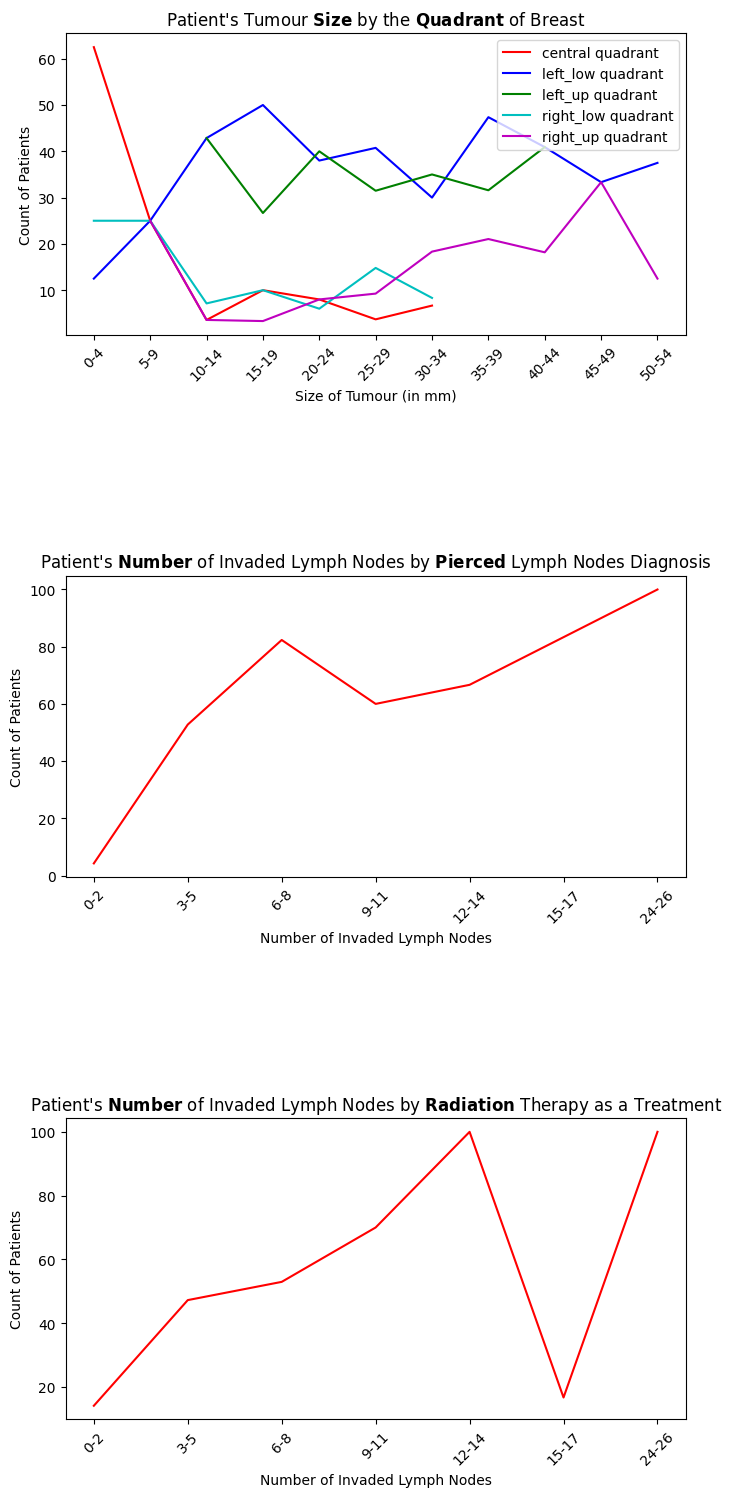

In [32]:
# create a subplot layout with three subplots
fig, (ax2, ax3, ax4) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [10,10,10]})
fig.set_size_inches(8,18)


ax2.plot(yax7, color = 'r', label='central quadrant')
ax2.plot(yax8, color = 'b', label='left_low quadrant')
ax2.plot(yax9, color = 'g', label='left_up quadrant')
ax2.plot(yax10, color = 'c', label='right_low quadrant')
ax2.plot(yax11, color = 'm', label='right_up quadrant')
ax2.legend(loc = 'upper right')

ax3.plot(yax2, color = 'r')

ax4.plot(yax12, color = 'r')



ax2.set_title(r"Patient's Tumour $\bf{Size}$ by the $\bf{Quadrant}$ of Breast")
ax3.set_title(r"Patient's $\bf{Number}$ of Invaded Lymph Nodes by $\bf{Pierced}$ Lymph Nodes Diagnosis")
ax4.set_title(r"Patient's $\bf{Number}$ of Invaded Lymph Nodes by $\bf{Radiation}$ Therapy as a Treatment")



ax2.set_xlabel('Size of Tumour (in mm)')
ax2.set_ylabel('Count of Patients')
ax2.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax2_labels = ['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54']
ax2.set_xticklabels(ax2_labels, rotation=45)

ax3.set_xlabel('Number of Invaded Lymph Nodes')
ax3.set_ylabel('Count of Patients')
ax3.set_xticks([0,1,2,3,4,5,6])
ax3_labels = ['0-2','3-5','6-8','9-11','12-14','15-17','24-26']
ax3.set_xticklabels(ax3_labels, rotation=45)

ax4.set_xlabel('Number of Invaded Lymph Nodes')
ax4.set_ylabel('Count of Patients')
ax4.set_xticks([0,1,2,3,4,5,6])
ax4_labels = ['0-2','3-5','6-8','9-11','12-14','15-17','24-26']
ax4.set_xticklabels(ax3_labels, rotation=45)

# show the figure
plt.subplots_adjust(hspace=0.8, wspace=0.6)
plt.show()

There is in fact a clear positive correlation between number of invaded lymph nodes and wether their capsule has been perforated or not.

##### Heuristic methodology

Using a *Heuristic methodology* based on the correlation analysis between the features I would predict if a patient is subject to have a recurrence event by looking at the degree of malignancy,tumour size as well as the number of invaded lymph nodes and wether their capsule resulted perforated.<br>
To make the *Heuristic methodology* more effective, I would compute an additional feature **Tumour Aggressivness**.

The degree of malignancy of a tumor is a measure of how abnormal the cells in the tumor are and how likely they are to spread to other parts of the body. It is usually based on the tumor's appearance under a microscope and other factors such as its size, location, and the presence of certain genetic mutations. Tumors that are more malignant are more likely to spread and be harder to treat.

The aggressiveness rate of a tumor, on the other hand, typically refers to how quickly a tumor is growing and spreading. It can also take into account factors such as the tumor's response to treatment and the likelihood of recurrence. Tumors that are more aggressive may be more likely to grow and spread rapidly, making them more difficult to treat.